In [584]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import datetime
from matplotlib import pyplot as plt 
import matplotlib.cm as cm
import numpy as np
from prophet import Prophet
import seaborn as sns
import plotly_express as px
pd.options.display.float_format='{:,.2f}'.format

In [585]:
df=pd.read_csv('telecom_customer_data.csv')

In [586]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               12000 non-null  object 
 1   date                      12000 non-null  object 
 2   city                      12000 non-null  object 
 3   plan_type                 12000 non-null  object 
 4   monthly_data_usage_gb     12000 non-null  float64
 5   number_of_complaints      12000 non-null  int64  
 6   monthly_revenue_usd       12000 non-null  float64
 7   network_downtime_minutes  12000 non-null  int64  
 8   churn                     12000 non-null  int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 843.9+ KB


Cleaning
----

In [587]:
df['date']=pd.to_datetime(df['date'])

In [588]:
df.tail()

,customer_id,date,city,plan_type,monthly_data_usage_gb,number_of_complaints,monthly_revenue_usd,network_downtime_minutes,churn
11995,CUST_1000,2023-08-01,Mansoura,Standard,36.27,1,25.39,10,0
11996,CUST_1000,2023-09-01,Mansoura,Standard,38.46,0,26.92,11,0
11997,CUST_1000,2023-10-01,Mansoura,Standard,105.91,1,74.14,27,0
11998,CUST_1000,2023-11-01,Mansoura,Standard,1.84,0,1.29,20,0
11999,CUST_1000,2023-12-01,Mansoura,Standard,28.75,0,20.12,9,0


In [589]:
latest_month=df['date'].max()
latest_date=df[df['date']==latest_month]
len(latest_date)


1000

In [590]:
customer_count=latest_date.groupby(['city','plan_type']).agg({
    'monthly_data_usage_gb':'sum',
    'number_of_complaints':'sum',
    'monthly_revenue_usd' : 'sum',
    'network_downtime_minutes':'sum',
    'customer_id':'nunique'
})
customer_count.rename(columns={'customer_id':'unique_customer'},inplace=True)
customer_count.sort_values(by='monthly_revenue_usd',ascending=False).head(10)


monthly_data_usage_gb  number_of_complaints  \
city       plan_type                                                
Mansoura   Premium                 1,722.55                    11   
Cairo      Premium                 1,529.56                     3   
Mansoura   Standard                2,066.40                    30   
Alexandria Premium                 1,359.93                     5   
Cairo      Standard                1,899.15                    23   
Asyut      Premium                 1,299.68                    10   
Giza       Premium                 1,294.95                     2   
           Standard                1,792.23                    25   
Alexandria Standard                1,726.91                    26   
Asyut      Standard                1,428.60                    35   

                      monthly_revenue_usd  network_downtime_minutes  \
city       plan_type                                                  
Mansoura   Premium               1,722.55                       716   
Cairo      Premium               1,529.56                       644   
Mansoura   Standard              1,446.48                      1174   
Alexandria Premium               1,359.93                       638   
Cairo      Standard              1,329.39                      1218   
Asyut      Premium               1,299.68                       537   
Giza       Premium               1,294.95                       543   
           Standard              1,254.57                      1014   
Alexandria Standard              1,208.85                      1044   
Asyut      Standard              1,000.02                      1066   

                      unique_customer  
city       plan_type                   
Mansoura   Premium                 49  
Cairo      Premium                 40  
Mansoura   Standard                79  
Alexandria Premium                 38  
Cairo      Standard                77  
Asyut      Premium                 38  
Giza       Premium                 36  
           Standard                75  
Alexandria Standard                74  
Asyut      Standard                74

In [591]:
df.columns

Index(['customer_id', 'date', 'city', 'plan_type', 'monthly_data_usage_gb',
       'number_of_complaints', 'monthly_revenue_usd',
       'network_downtime_minutes', 'churn'],
      dtype='object')

In [592]:
features=df[['monthly_data_usage_gb','number_of_complaints', 'monthly_revenue_usd','network_downtime_minutes']]

scaler=StandardScaler()
features_scaled=scaler.fit_transform(features)

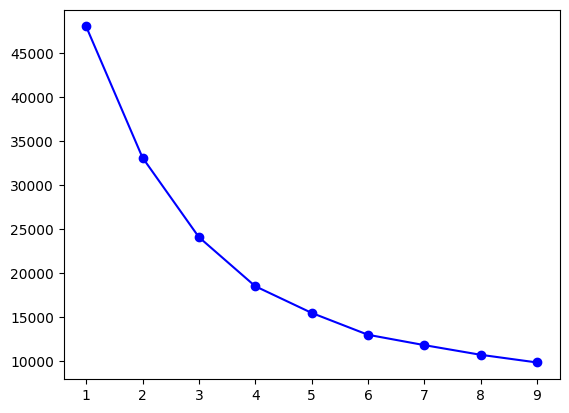

In [593]:
inrtia=[]
K=range(1,10)
for k in K :
    kmeans=KMeans(n_clusters=k,random_state=42)
    kmeans.fit(features_scaled)
    inrtia.append(kmeans.inertia_)
plt.plot(K,inrtia,'bo-')    

In [ ]:
kmeans=KMeans(n_clusters=3,random_state=42)
df['cluster']=kmeans.fit_predict(features_scaled)

In [595]:
cluster=df.groupby('cluster')[['monthly_data_usage_gb','number_of_complaints', 'monthly_revenue_usd','network_downtime_minutes']].mean().reset_index()
cluster

,cluster,monthly_data_usage_gb,number_of_complaints,monthly_revenue_usd,network_downtime_minutes
0,0,17.03,1.22,11.12,14.53
1,1,86.47,0.21,75.08,14.27
2,2,16.44,0.00,11.30,14.61


In [596]:
clusters=df.groupby('cluster')[['monthly_data_usage_gb','number_of_complaints', 'monthly_revenue_usd','network_downtime_minutes']].sum().reset_index()
clusters

,cluster,monthly_data_usage_gb,number_of_complaints,monthly_revenue_usd,network_downtime_minutes
0,0,"57,871.66",4147,"37,791.35",49386
1,1,"104,712.24",258,"90,921.35",17279
2,2,"121,509.41",0,"83,501.85",108006


In [597]:
cluster_summary=cluster.melt(id_vars='cluster',value_name='value',var_name='features')
cluster_summary

,cluster,features,value
0,0,monthly_data_usage_gb,17.03
1,1,monthly_data_usage_gb,86.47
2,2,monthly_data_usage_gb,16.44
3,0,number_of_complaints,1.22
4,1,number_of_complaints,0.21
5,2,number_of_complaints,0.00
6,0,monthly_revenue_usd,11.12
7,1,monthly_revenue_usd,75.08
8,2,monthly_revenue_usd,11.30
9,0,network_downtime_minutes,14.53


In [598]:
px.bar(cluster_summary,x='cluster',y='value',color='features', barmode='group', text='value',title='Feature Comparison Across Clusters',labels={'cluster':'Features','value':'Value'}, color_discrete_sequence=px.colors.sequential.Viridis).update_traces(texttemplate='%{text:.1f}',)

In [599]:
for i in df['cluster'].unique():
    df[df['cluster']==i].to_csv(f"cluster{i}_customer.csv",index=False)

In [600]:
df['month']=df['date'].dt.to_period('M').dt.to_timestamp()

In [601]:
df.columns

Index(['customer_id', 'date', 'city', 'plan_type', 'monthly_data_usage_gb',
       'number_of_complaints', 'monthly_revenue_usd',
       'network_downtime_minutes', 'churn', 'cluster', 'month'],
      dtype='object')

In [602]:
cluster_plan_count=df.groupby(['cluster','plan_type'])['customer_id'].nunique().reset_index()
cluster_plan_countc=df.groupby(['cluster','city'])['customer_id'].nunique().reset_index()
cluster_plan_count
# result=cluster_plan_countc[cluster_plan_countc['cluster']==0]
# result

,cluster,plan_type,customer_id
0,0,Basic,419
1,0,Premium,167
2,0,Standard,374
3,1,Basic,63
4,1,Premium,198
5,1,Standard,249
6,2,Basic,420
7,2,Premium,201
8,2,Standard,379


In [603]:
monthly_summry=df.groupby('month').agg({
    'monthly_revenue_usd':'sum',
    'number_of_complaints':'sum',
    'monthly_data_usage_gb':'mean',
    'customer_id':'nunique'
}).reset_index()

monthly_summry.rename(columns={'monthly_revenue_usd':'total revenue','number_of_complaints':'total complaints','monthly_data_usage_gb':'avg_data_usage','customer_id':'active_customer'},inplace=True)

In [604]:
monthly_summry

,month,total revenue,total complaints,avg_data_usage,active_customer
0,2023-01-01,"18,105.59",379,24.01,1000
1,2023-02-01,"17,404.72",378,23.66,1000
2,2023-03-01,"18,544.40",384,24.78,1000
3,2023-04-01,"17,924.30",369,24.13,1000
4,2023-05-01,"18,172.27",370,23.89,1000
5,2023-06-01,"17,848.34",370,23.89,1000
6,2023-07-01,"16,581.32",364,22.18,1000
7,2023-08-01,"17,326.16",366,23.49,1000
8,2023-09-01,"16,960.36",344,23.03,1000
9,2023-10-01,"18,976.27",381,25.01,1000


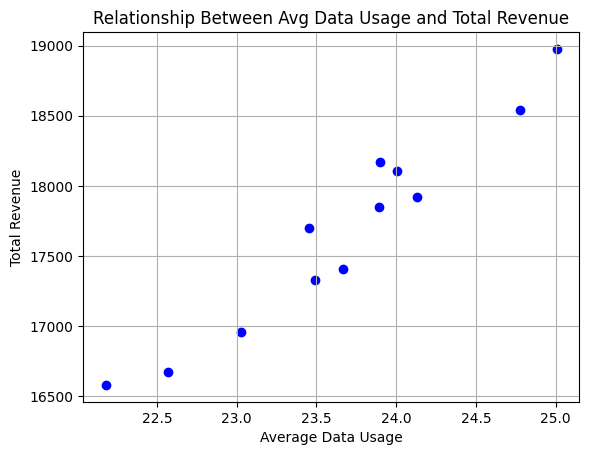

In [ ]:
plt.scatter(monthly_summry['avg_data_usage'], monthly_summry['total revenue'], color='blue')
plt.xlabel('Average Data Usage')
plt.ylabel('Total Revenue')
plt.title('Relationship Between Avg Data Usage and Total Revenue')
plt.grid(True)
plt.show()

In [605]:
rev_plan=df.groupby('plan_type')['monthly_revenue_usd'].sum().reset_index()
comp_plan=df.groupby('plan_type')['number_of_complaints'].sum().reset_index()
rev_plan

,plan_type,monthly_revenue_usd
0,Basic,"37,928.49"
1,Premium,"95,072.23"
2,Standard,"79,213.83"


In [606]:
avg_rev=df.groupby('plan_type')['monthly_revenue_usd'].mean().reset_index()
avg_comp=df.groupby('plan_type')['number_of_complaints'].mean().reset_index()
plan_summary=avg_rev.merge(avg_comp,on='plan_type')
plan_summary = plan_summary.rename(columns={'monthly_revenue_usd': 'avg_revenue', 'number_of_complaints': 'avg_complaints'})
plan_summary

,plan_type,avg_revenue,avg_complaints
0,Basic,7.53,0.41
1,Premium,39.42,0.20
2,Standard,17.42,0.41


In [607]:
mean_rev = plan_summary['avg_revenue'].mean()
mean_comp = plan_summary['avg_complaints'].mean()

In [608]:
low_plan_perf = plan_summary[
    (plan_summary['avg_revenue'] < mean_rev) & 
    (plan_summary['avg_complaints'] > mean_comp)
]

low_plan_perf

,plan_type,avg_revenue,avg_complaints
0,Basic,7.53,0.41
2,Standard,17.42,0.41


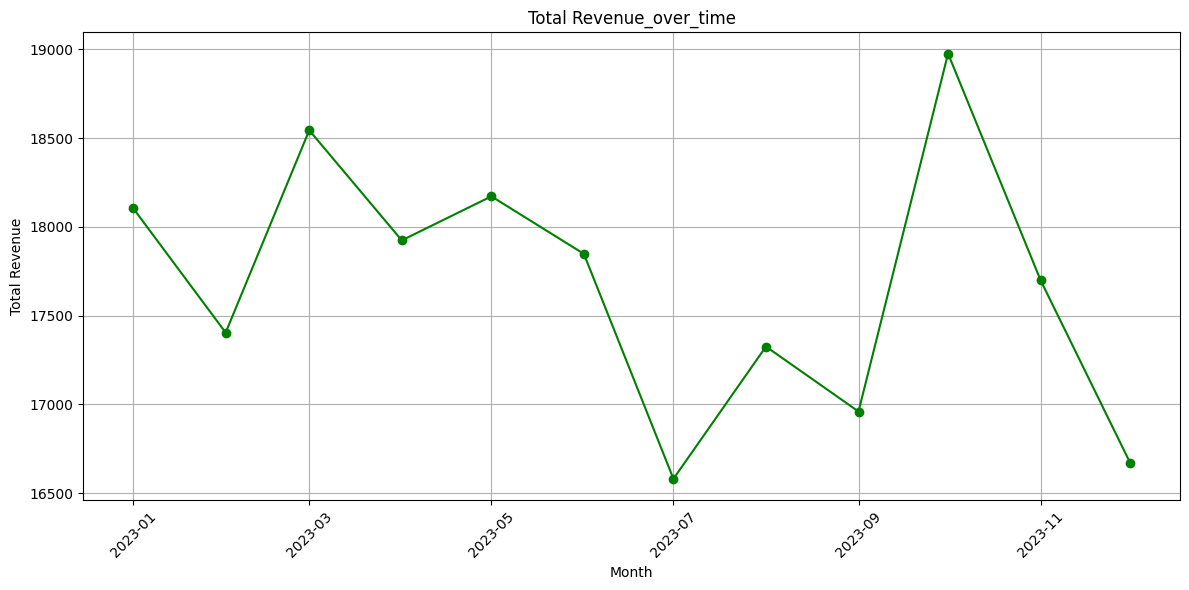

In [638]:
columns = ['total revenue']

for col in columns :
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_summry['month'],monthly_summry[col] ,marker='o', color='green')
    plt.title(f'{col.title()}_over_time')
    plt.xlabel('Month')
    plt.ylabel(f'{col.title()}')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

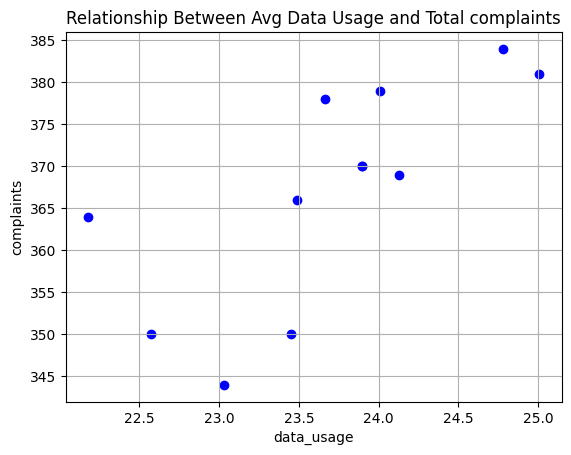

In [631]:
plt.scatter(monthly_summry['avg_data_usage'], monthly_summry['total complaints'], color='blue')
plt.xlabel('data_usage')
plt.ylabel('complaints')
plt.title('Relationship Between Avg Data Usage and Total complaints')
plt.grid(True)
plt.show()

In [610]:
df.head()

,customer_id,date,city,plan_type,monthly_data_usage_gb,number_of_complaints,monthly_revenue_usd,network_downtime_minutes,churn,cluster,month
0,CUST_0001,2023-01-01,Mansoura,Premium,36.52,0,36.52,18,0,2,2023-01-01
1,CUST_0001,2023-02-01,Mansoura,Premium,4.21,0,4.21,20,0,2,2023-02-01
2,CUST_0001,2023-03-01,Mansoura,Premium,36.76,0,36.76,21,0,2,2023-03-01
3,CUST_0001,2023-04-01,Mansoura,Premium,2.32,0,2.32,29,0,2,2023-04-01
4,CUST_0001,2023-05-01,Mansoura,Premium,9.55,0,9.55,20,0,2,2023-05-01


In [611]:
monthly_rev = df.groupby('month')['monthly_revenue_usd'].sum().reset_index()
actual_rev = monthly_rev.rename(columns={'month': 'ds', 'monthly_revenue_usd': 'y'})
train = actual_rev.iloc[:-3]
test = actual_rev.iloc[-3:]

model = Prophet()
model.fit(train)

future = model.make_future_dataframe(periods=6, freq='M')
final_forecast = model.predict(future)

test['ds'] = test['ds'].dt.to_period('M')
final_forecast['ds'] = final_forecast['ds'].dt.to_period('M')

forecast_test = final_forecast[final_forecast['ds'].isin(test['ds'])]

y_true = test.set_index('ds').loc[forecast_test['ds'], 'y']
y_pred = forecast_test['yhat']
mae = mean_absolute_error(y_true, y_pred)
print(f"ناتج الـ MAE = {mae}")


01:48:56 - cmdstanpy - INFO - Chain [1] start processing
01:48:56 - cmdstanpy - INFO - Chain [1] done processing


ناتج الـ MAE = 1168.4802107881867


C:\Users\Mr.Omar\AppData\Roaming\Python\Python312\site-packages\prophet\forecaster.py:1854: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

C:\Users\Mr.Omar\AppData\Local\Temp\ipykernel_11392\2360716351.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Forecasting
---

01:48:56 - cmdstanpy - INFO - Chain [1] start processing
01:48:56 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Mr.Omar\AppData\Roaming\Python\Python312\site-packages\prophet\forecaster.py:1854: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



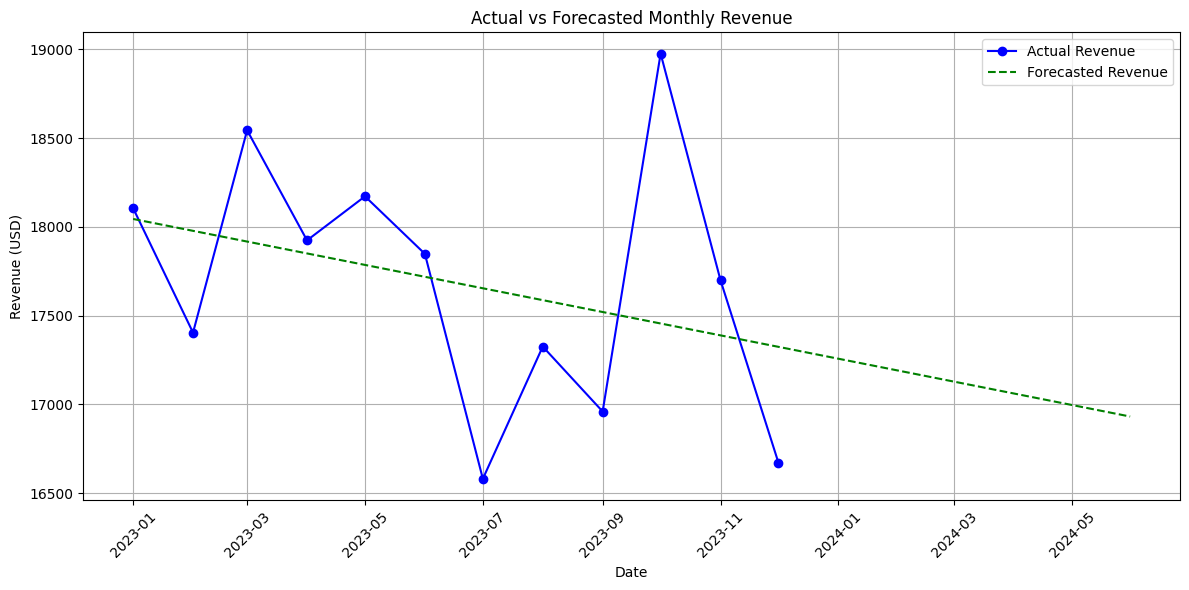

In [612]:
model = Prophet()
model.fit(actual_rev)
future = model.make_future_dataframe(periods=6, freq='M')
forecast = model.predict(future)
plt.figure(figsize=(12, 6))

# الإيرادات الفعلية (الحقيقية)
plt.plot(actual_rev['ds'], actual_rev['y'], label='Actual Revenue', marker='o', color='blue')

# الإيرادات المتوقعة من Prophet
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Revenue', linestyle='--', color='green')

plt.title('Actual vs Forecasted Monthly Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue (USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [613]:
df=pd.get_dummies(df,columns=['plan_type','city'],drop_first=True)
bool=df.select_dtypes(include='bool').columns
df[bool]=df[bool].astype(int)

In [614]:
df['month']=pd.to_datetime(df['month']).dt.month
X=df.drop(['customer_id','date','churn','cluster','month'],axis=1)
y=df['churn']


In [615]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
model=RandomForestClassifier(random_state=42)
model.fit(X_train_res, y_train_res)

RandomForestClassifier(random_state=42)

In [616]:
y_pred=model.predict(X_test)

In [617]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1-Score: {f1_score(y_test, y_pred)}")

Accuracy: 0.7170833333333333
Precision: 0.16176470588235295
Recall: 0.21568627450980393
F1-Score: 0.18487394957983194


In [618]:
df['churn_pred'] = model.predict(X)
churn_risk_customer=df[df['churn_pred']==1]
churn_risk_customer['pred_date']= datetime.datetime.today().date()
churn_risk_customer.to_excel('churn_risk_customers.xlsx', index=False)

C:\Users\Mr.Omar\AppData\Local\Temp\ipykernel_11392\1786958629.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [619]:
def get_plan_name(row):
    if row ['plan_type_Premium']==1:
        return 'premium'
    elif row['plan_type_Standard']==1:
        return 'standard'
    else:
        return 'basic'
churn_risk_customer['plan_type']=churn_risk_customer.apply(get_plan_name,axis=1)

C:\Users\Mr.Omar\AppData\Local\Temp\ipykernel_11392\2034958006.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [620]:
churn_risk_customer.plan_type.value_counts().reset_index()

,plan_type,count
0,basic,797
1,standard,677
2,premium,421


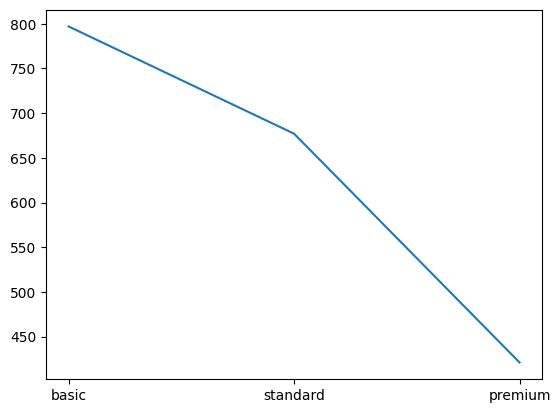

In [637]:
plt.plot(churn_risk_customer.plan_type.value_counts())

In [621]:
def get_city_name(row):
    if row ['city_Asyut']==1:
        return 'Asyut'
    elif row['city_Cairo']==1:
        return 'Cairo'
    elif row['city_Giza']:
        return 'Giza'
    elif row['city_Mansoura']:
        return 'Mansoura'
    else:
        return 'Alexandria'
churn_risk_customer['city_name']=churn_risk_customer.apply(get_city_name,axis=1)

C:\Users\Mr.Omar\AppData\Local\Temp\ipykernel_11392\1375003517.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [622]:
churn_risk_customer['city_name'].value_counts().reset_index()

,city_name,count
0,Alexandria,567
1,Mansoura,397
2,Asyut,335
3,Cairo,328
4,Giza,268


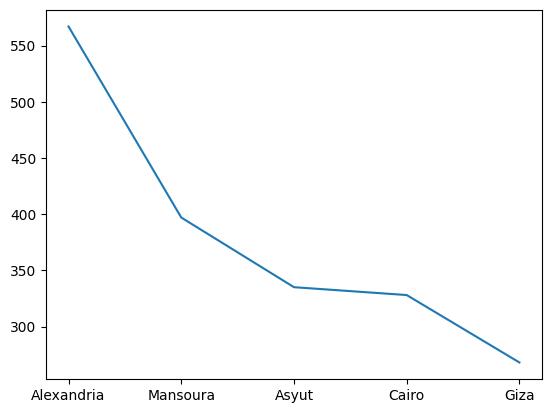

In [635]:
plt.plot(churn_risk_customer['city_name'].value_counts())

In [623]:
pd.crosstab(churn_risk_customer['plan_type'], churn_risk_customer['city_name'])


city_name,Alexandria,Asyut,Cairo,Giza,Mansoura
plan_type,,,,,
basic,248,95,175,88,191
premium,113,71,108,72,57
standard,206,169,45,108,149
